pip install dask[complete]
pip install pyarrow
pip install s3fs
pip install graphviz

In [38]:
import dask

import dask.dataframe as dd
from dask.distributed import Client

import pandas as pd

import numpy as np
import dask.array as da

import time

In [10]:
%run prep.py -d flights

- Downloading NYC Flights dataset... done
- Extracting flight data... done
- Creating json data... done
** Created flights dataset! in 5.91s**


# Dask Dataframes

In [11]:
ddf = dd.read_csv(
    os.path.join("data", "nycflights", "*.csv"), parse_dates={"Date": [0, 1, 2]}
)

In [12]:
ddf.head()

Date  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
0 1990-01-01          1   1621.0        1540   1747.0        1701   
1 1990-01-02          2   1547.0        1540   1700.0        1701   
2 1990-01-03          3   1546.0        1540   1710.0        1701   
3 1990-01-04          4   1542.0        1540   1710.0        1701   
4 1990-01-05          5   1549.0        1540   1706.0        1701   

  UniqueCarrier  FlightNum  TailNum  ActualElapsedTime  ...  AirTime  \
0            US         33      NaN               86.0  ...      NaN   
1            US         33      NaN               73.0  ...      NaN   
2            US         33      NaN               84.0  ...      NaN   
3            US         33      NaN               88.0  ...      NaN   
4            US         33      NaN               77.0  ...      NaN   

   ArrDelay  DepDelay  Origin Dest Distance  TaxiIn  TaxiOut  Cancelled  \
0      46.0      41.0     EWR  PIT    319.0     NaN      NaN          0   
1      -1.0       7.0     EWR  PIT    319.0     NaN      NaN          0   
2       9.0       6.0     EWR  PIT    319.0     NaN      NaN          0   
3       9.0       2.0     EWR  PIT    319.0     NaN      NaN          0   
4       5.0       9.0     EWR  PIT    319.0     NaN      NaN          0   

   Diverted  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 21 columns]

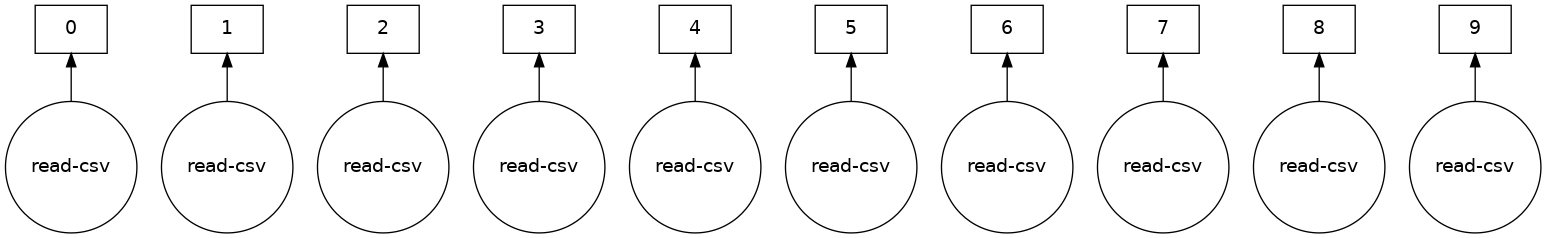

In [15]:
ddf.visualize()

### Operation on multiple files in Pandas

In [17]:
files = os.listdir(os.path.join('data', 'nycflights'))

In [18]:
maxes = []

for file in files:
    df = pd.read_csv(os.path.join('data', 'nycflights', file))
    maxes.append(df.DepDelay.max())

final_max = max(maxes)

In [19]:
print(final_max)

1435.0


### Operation on multiple files in Dask

In [20]:
result = ddf.DepDelay.max()
result.compute()

1435.0

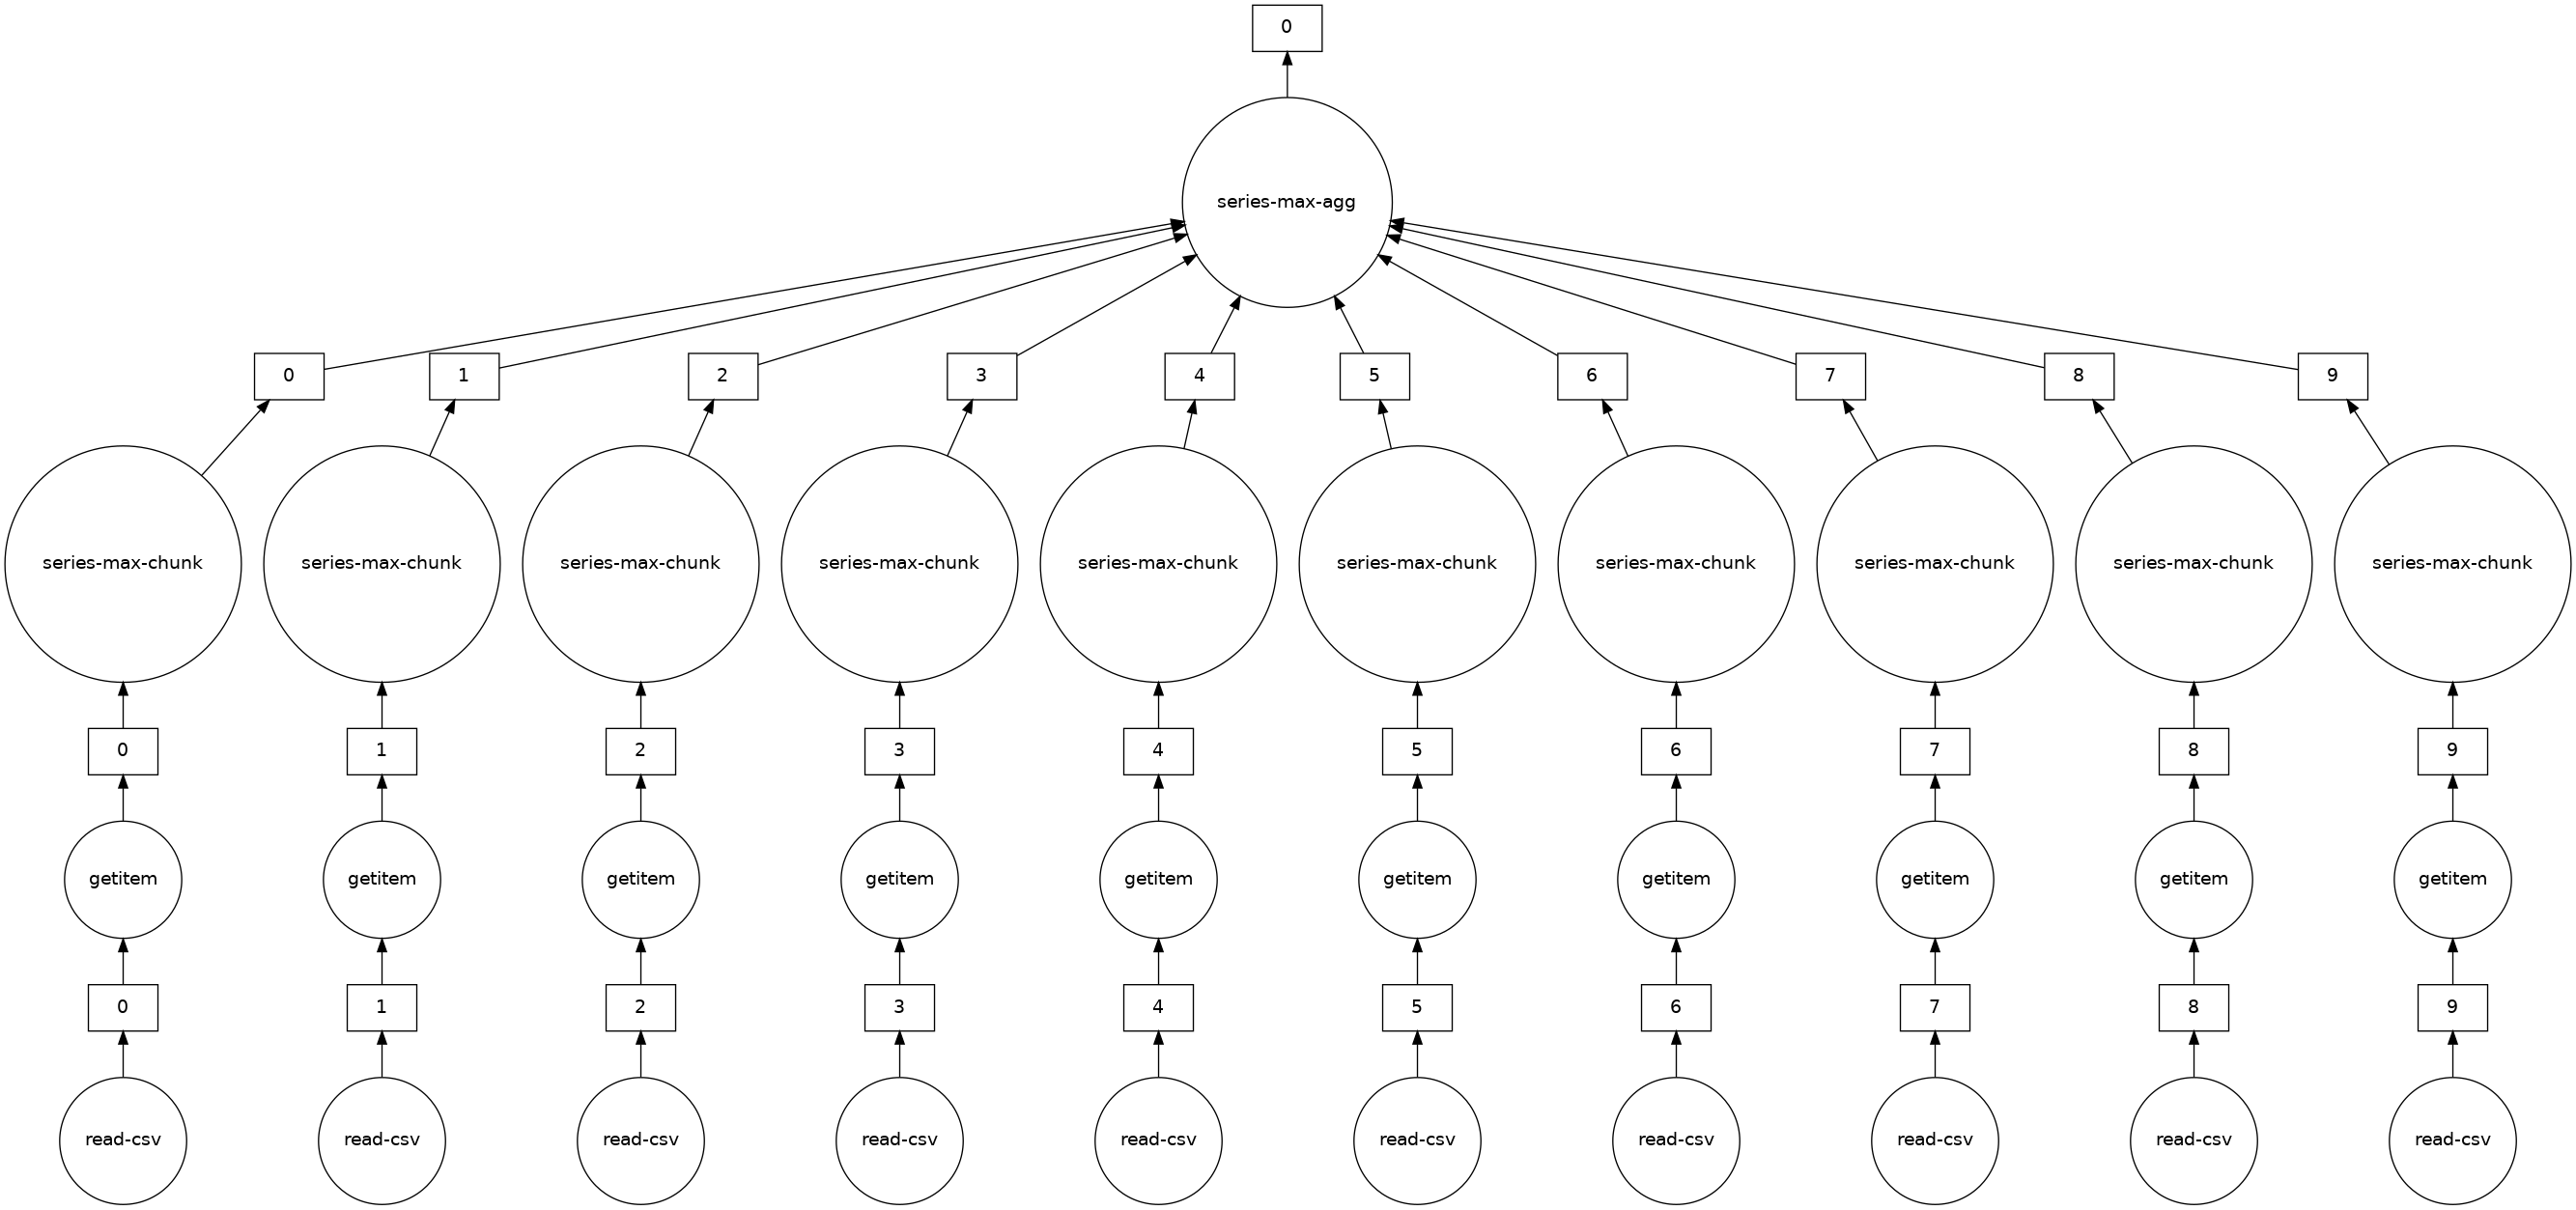

In [22]:
result.visualize()

# Dask  Arrays - parallelized numpy

In [24]:

# NumPy array
a_np = np.ones(10)
a_np

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [26]:
a_np_sum = a_np[:5].sum() + a_np[5:].sum()
a_np_sum

10.0

In [25]:
# Dask array
a_da = da.ones(10, chunks=5)
a_da

dask.array<ones_like, shape=(10,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>

In [27]:
a_da_sum = a_da.sum()
a_da_sum

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

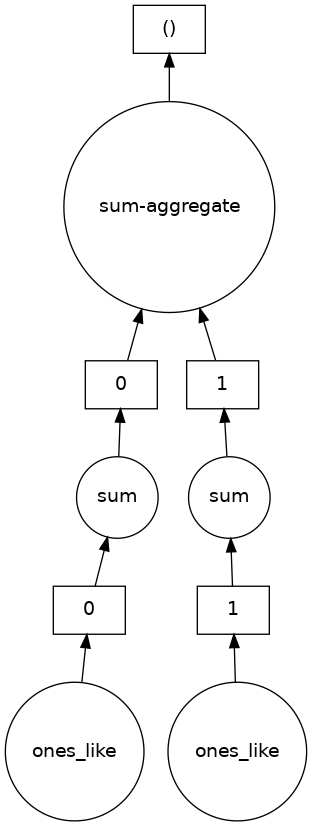

In [30]:
a_da_sum.visualize()

In [31]:
a_da_sum.compute()

10.0

# Delayed decorator

A Bloack of code can have operations that can happen in parallel. But normally in python this would happen sequentially or the user will identify the paralle section and write parallel codes. 

The Dask **delayed** function decorates your functions so that they operate lazily. Rather than executing your function immediately, it will defer execution, placing the function and its arguments into a task graph.

Dask will then identify oppurtunities for parallelism in the task graph. The Dask schedulers will exploit this parallelism, generally improving performance.

In [52]:
@dask.delayed
def inc(x):
    time.sleep(1)
    return x + 1




#### As the two increments are independent of each other, we can run them in parallel

In [ ]:
@dask.delayed
def add(x, y):
    time.sleep(1)
    return x + y

In [45]:
x = inc(1)
y = inc(2)
z = add(x, y)

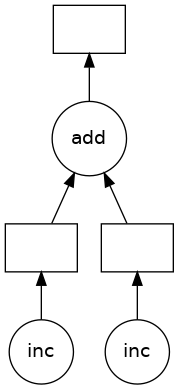

In [46]:
# Here Z is a delayed object
z.visualize()

In [47]:
z.compute()

5

# Dask future

In futures interface we can submit individual functions for evaluation. The call returns immediately, giving one or more futures, whose status begins as “pending” and later becomes “finished”. There is no **blocking** of the local Python session.

This is the important difference between futures and delayed. Both can be used to support arbitrary task scheduling, but delayed is lazy (it just constructs a graph) whereas futures are eager. With futures, as soon as the inputs are available and there is compute available, the computation starts.

In [48]:
def inc(x):
    time.sleep(1)
    return x + 1


def double(x):
    sleep(2)
    return 2 * x


def add(x, y):
    time.sleep(1)
    return x + y

In [49]:
future = client.submit(inc, 1)  # returns immediately with pending future
future

<Future: pending, key: inc-4a2f5295e8c9c2552f2955cd544453ab>

#### If we check the future after a few seconds we can see that it is complete

In [50]:
future

<Future: finished, type: int, key: inc-4a2f5295e8c9c2552f2955cd544453ab>

In [51]:

future.result()

2